# **Case Técnico – Cientista de Dados Júnior | Datarisk (Modelagem)**

Nesta etapa desenvolvo um modelo preditivo para estimar a probabilidade de inadimplência associada às cobranças mensais dos clientes. Esse tipo de solução é conhecido no mercado como modelo de PD (Probability of Default), amplamente utilizado em operações de análise e gestão de risco de crédito.

O objetivo é identificar, com antecedência, quais clientes apresentam maior propensão a atrasar o pagamento em 5 dias ou mais, conforme definido no problema. Para isso, serão avaliadas diferentes abordagens de modelagem, buscando um equilíbrio entre desempenho preditivo, interpretabilidade e robustez temporal.

Dentre os algoritmos considerados, utilizarei:

Regressão Logística: modelo clássico em risco de crédito, interpretável e adequado como baseline para avaliação inicial de performance.

XGBoost (Extreme Gradient Boosting): método ensemble baseado em árvores de decisão, capaz de capturar relações não lineares e interações complexas entre variáveis, frequentemente apresentando ganhos de performance em comparação a modelos lineares.

A comparação entre essas abordagens permitirá identificar o modelo mais consistente para prever inadimplência no contexto operacional da empresa, garantindo maior precisão na priorização de ações de cobrança.



### **Importando as bibliotecas**

#### **Manipulação e Estruturação de Dados**

* **pandas (pd)** – Leitura, tratamento e manipulação de DataFrames.
* **numpy (np)** – Operações numéricas vetorizadas e funções matemáticas.

#### **Visualização**

* **matplotlib / pyplot (mpl, plt)** – Criação de gráficos básicos e customização de estilo.
* **seaborn (sns)** – Visualizações estatísticas de alto nível, com paletas personalizadas.

#### **Modelagem e Machine Learning (scikit-learn)**

* **Pipeline** – Encadeamento de pré-processamento + modelo de forma reprodutível.
* **LogisticRegression** – Modelo base para previsão de inadimplência (PD model).
* **SimpleImputer** – Tratamento de valores faltantes.
* **StandardScaler** – Padronização de variáveis numéricas.
* **OneHotEncoder** – Transformação de variáveis categóricas.
* **ColumnTransformer** – Aplicação de diferentes transformações por tipo de coluna.

#### **Métricas de Avaliação**

* **roc_auc_score, roc_curve** – Métricas centrais para modelos de risco.
* **brier_score_loss** – Avaliação de calibração.
* **f1_score, recall_score** – Métricas para análise pós-cutoff.
* **confusion_matrix** – Relação entre previsões positivas/negativas.

#### **Configurações e Estilo**

* Definição de estilos visuais (ggplot, cores, grid).
* Paletas personalizadas para padronização dos gráficos.
* Suppressão de warnings irrelevantes.


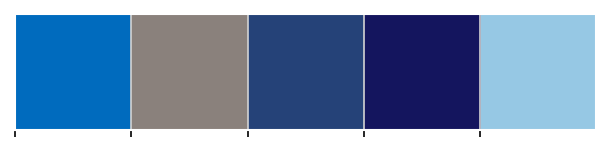

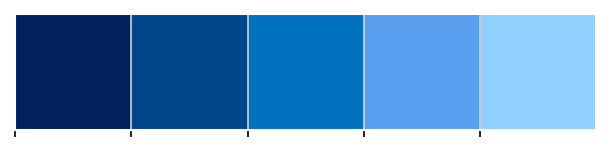

In [29]:
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, f1_score, recall_score, confusion_matrix, precision_score 
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from src.modelling_utils import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

mpl.style.use('ggplot')
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

# Palette
instyle_palette = ['#006bbe', '#8a817c', '#254278', "#14155E", '#96c8e4']
progress_palette = ['#00215d', '#00468b', '#0071bc', '#589fef', '#8fd0ff']


sns.set_palette(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(progress_palette))

### **Carregamento e Preparação Inicial dos Dados**

A função read_and_clean_data é responsável por realizar a leitura dos arquivos brutos a partir dos caminhos fornecidos. Após o carregamento, essa função aplica as correções, padronizações e tratamentos definidos durante a etapa de EDA, garantindo que todos os datasets utilizados na modelagem estejam consistentes, limpos e prontos para integração.

In [30]:
df = read_and_clean_data('../data/processed/base_pagamentos_desenvolvimento.xlsx', file_type='xlsx')

In [31]:
df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN


Para garantir consistência entre as bases e melhorar a capacidade preditiva do modelo, foram extraídos **dia, mês e ano** das variáveis temporais. Essa decomposição facilita a interpretação dos padrões sazonais, reduz a complexidade dos dados de data e permite que o modelo capture melhor efeitos como:

* variações mensais ou sazonais de inadimplência;
* comportamento associado ao dia de vencimento;
* envelhecimento da relação cliente–empresa ao longo do tempo.

Além disso, a transformação torna as features mais explicáveis e adequadas para algoritmos lineares e baseados em árvores, preservando integridade e reprodutibilidade na etapa de modelagem.


In [32]:
df['DIA_VENCIMENTO_DOCUMENTO'] = (df['DATA_VENCIMENTO']).dt.day
df['MES_VENCIMENTO_DOCUMENTO'] = (df['DATA_VENCIMENTO']).dt.month
df['ANO_VENCIMENTO_DOCUMENTO'] = (df['DATA_VENCIMENTO']).dt.year
df['TEMPO_DE_PAGAMENTO'] = (df['DATA_VENCIMENTO'] - df['DATA_EMISSAO_DOCUMENTO']).dt.days
df['DIA_REF'] = (df['SAFRA_REF']).dt.day
df['MES_REF'] = (df['SAFRA_REF']).dt.month
df['ANO_REF'] = (df['SAFRA_REF']).dt.year

df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,ANO_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN,6,9,2018,20,1,8,2018
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,2018,19,1,8,2018
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,2018,19,1,8,2018
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,6,9,2018,16,1,8,2018
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,5,9,2018,16,1,8,2018


Para a variável DATA_CADASTRO, foi criado o tempo de relacionamento do cliente até a data da cobrança, calculado como a diferença em meses entre DATA_CADASTRO e SAFRA_REF.

In [33]:
df['TEMPO_RELACIONAMENTO'] = (
    (df['SAFRA_REF'].dt.year - df['DATA_CADASTRO'].dt.year) * 12 +
    (df['SAFRA_REF'].dt.month - df['DATA_CADASTRO'].dt.month)
)

df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,ANO_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF,TEMPO_RELACIONAMENTO
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65.0,9,6,NaN,NaN,6,9,2018,20,1,8,2018,60
1,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,210851.55,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,2018,19,1,8,2018,36
2,5726178124659660800,2018-08-01,2018-08-22,2018-09-10,2018-09-10,153540.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,10,9,2018,19,1,8,2018,36
3,5726178124659660800,2018-08-01,2018-08-21,2018-09-06,2018-09-06,75064.00,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,6,9,2018,16,1,8,2018,36
4,5726178124659660800,2018-08-01,2018-08-20,2018-09-05,2018-09-05,80550.14,5.99,0,2015-08-16,63,0,Indústria,GMAIL,MEDIO,68.0,6,6,NaN,NaN,5,9,2018,16,1,8,2018,36


Após extrair os componentes relevantes das datas (dia, mês e ano) e calcular as métricas temporais necessárias, as colunas originais de data podem ser removidas. Isso evita redundância, reduz dimensionalidade e previne que informações não estruturadas em formato de data impactem negativamente o modelo. Deixarei apenas SAFRA_REF para realizar a separação entre treino e teste, entretanto, ao fazer a separação, ela também será removida.

In [34]:
cols_to_drop = ['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'DDD', 'CEP_2_DIG', 'DATA_CADASTRO']

df.drop(cols_to_drop, axis=1, inplace=True)

df.head()

,SAFRA_REF,VALOR_A_PAGAR,TAXA,TARGET,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,REGIAO_DDD,REGIAO_CEP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DIA_VENCIMENTO_DOCUMENTO,MES_VENCIMENTO_DOCUMENTO,ANO_VENCIMENTO_DOCUMENTO,TEMPO_DE_PAGAMENTO,DIA_REF,MES_REF,ANO_REF,TEMPO_RELACIONAMENTO
0,2018-08-01,35516.41,6.99,0,0,Serviços,YAHOO,PEQUENO,9,6,NaN,NaN,6,9,2018,20,1,8,2018,60
1,2018-08-01,210851.55,5.99,0,0,Indústria,GMAIL,MEDIO,6,6,NaN,NaN,10,9,2018,19,1,8,2018,36
2,2018-08-01,153540.00,5.99,0,0,Indústria,GMAIL,MEDIO,6,6,NaN,NaN,10,9,2018,19,1,8,2018,36
3,2018-08-01,75064.00,5.99,0,0,Indústria,GMAIL,MEDIO,6,6,NaN,NaN,6,9,2018,16,1,8,2018,36
4,2018-08-01,80550.14,5.99,0,0,Indústria,GMAIL,MEDIO,6,6,NaN,NaN,5,9,2018,16,1,8,2018,36


### **Separação: Treino e Teste**

Para garantir consistência temporal e evitar que o modelo tenha acesso a informações futuras, foi adotado um split Out-of-Time (OOT). Esse tipo de divisão utiliza períodos mais antigos para treino e períodos mais recentes para teste, respeitando a cronologia natural das cobranças. Dessa forma, avaliamos o modelo em um cenário que simula corretamente sua aplicação real, onde previsões são feitas sempre para períodos posteriores aos utilizados no treinamento.

In [35]:
train, test = np.split(df, [int(.80 * len(df))])

train['SET'] = 'train'
test['SET'] = 'test'

In [36]:
print(f"Taxa de inadimplente conjunto de treino:\n {train['TARGET'].value_counts(normalize=True)}.")
print()
print(f"Taxa de inadimplente conjunto de teste:\n {test['TARGET'].value_counts(normalize=True)}.")

Taxa de inadimplente conjunto de treino:
 TARGET
0    0.927968
1    0.072032
Name: proportion, dtype: float64.

Taxa de inadimplente conjunto de teste:
 TARGET
0    0.937028
1    0.062972
Name: proportion, dtype: float64.


In [37]:
print(f'O conjunto de treino tem {train.shape[0]} linhas e {train.shape[1]} colunas')
print(f'O conjunto de teste tem {test.shape[0]} linhas e {test.shape[1]} colunas')

O conjunto de treino tem 61931 linhas e 21 colunas
O conjunto de teste tem 15483 linhas e 21 colunas


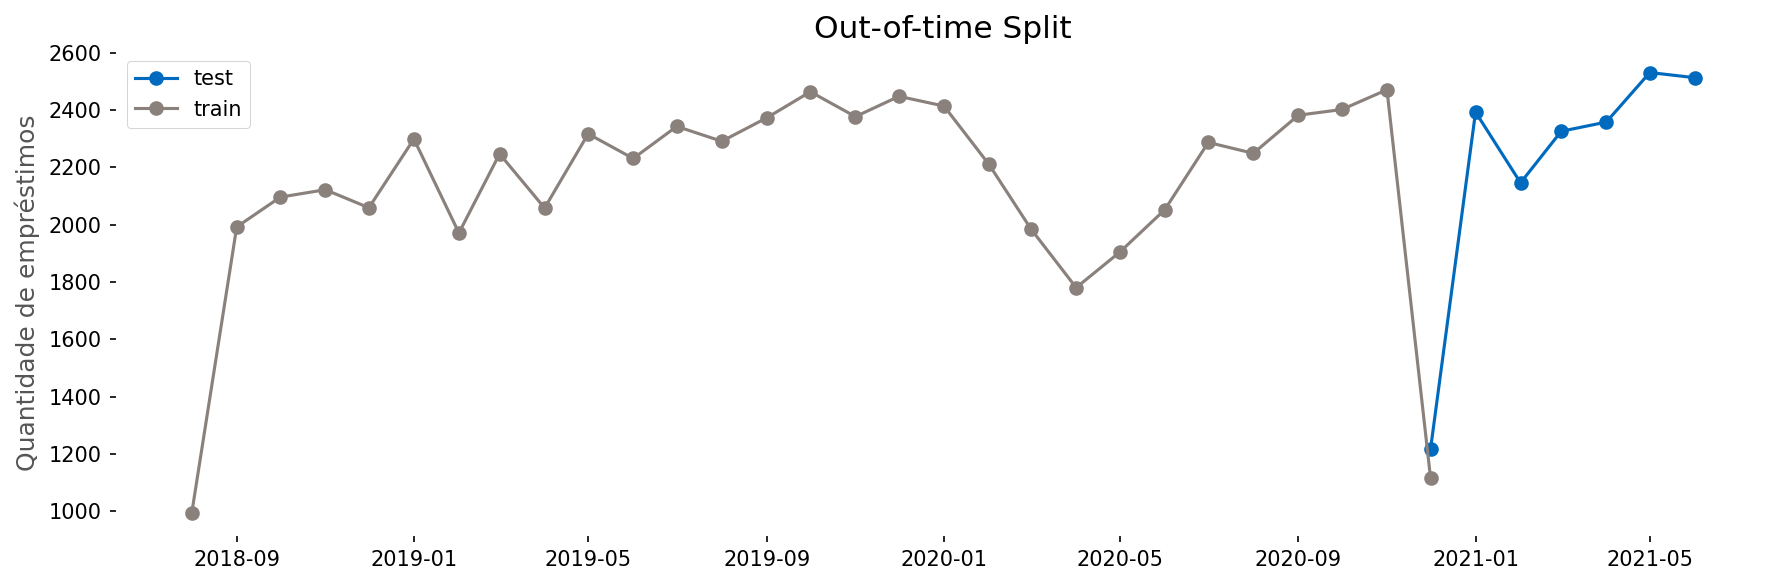

In [38]:
train_test = pd.concat([train, test])
train_test = (
    train_test
    .groupby(['SAFRA_REF', 'SET'])['TARGET']
    .count()
    .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Out-of-time Split', fontsize=15)

for set_name, df_set in train_test.groupby('SET'):
    ax.plot(df_set['SAFRA_REF'], df_set['TARGET'], marker='o', label=set_name)

ax.set_ylabel('Quantidade de empréstimos')
ax.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Observamos o OoT Split no gráfico acima. Em cinza, estão os dados de treinamento e em azul, os dados de teste. O intuito é respeitar a ordem cronólogica das cobranças e garantir que o modelo seja avaliado em um cenário realista, o qual previsões são feitas apenas em períodos futuros em relação aos dados de treinamento. 

In [39]:
missing_df = df.isna().sum().to_frame().rename(columns={0: 'count'}).sort_values(by=['count'], ascending=False)
missing_df['pct'] = round(missing_df['count'] / df.shape[0] * 100, 3)
missing_df.head(10)

,count,pct
NO_FUNCIONARIOS,4135,5.341
RENDA_MES_ANTERIOR,4017,5.189
PORTE,2476,3.198
REGIAO_DDD,1821,2.352
SEGMENTO_INDUSTRIAL,1417,1.830
DOMINIO_EMAIL,898,1.160
VALOR_A_PAGAR,27,0.035
REGIAO_CEP,8,0.010
TARGET,0,0.000
TAXA,0,0.000


### **Análise de Valores Ausentes**

A tabela acima apresenta a quantidade e o percentual de valores faltantes por variável no dataset. Observamos que:

* **REGIAO_DDD** e **NO_FUNCIONARIOS** possuem os maiores percentuais de missing, acima de 5%.
* Variáveis como **RENDA_MES_ANTERIOR**, **PORTE** e **SEGMENTO_INDUSTRIAL** apresentam níveis moderados de ausência.
* A maior parte das variáveis apresenta **pouco ou nenhum missing**, o que reduz a necessidade de tratamentos agressivos.

Com base nesses resultados, aplicaremos estratégias de imputação adequadas ao tipo da variável (numérica ou categórica), garantindo consistência durante o pré-processamento e evitando perda de informação.

### **Modelagem -> Baseline**


In [40]:
X_train = train.drop('TARGET', axis=1)
y_train = train['TARGET']
X_test = test.drop('TARGET', axis=1)
y_test = test['TARGET']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((61931, 20), (61931,), (15483, 20), (15483,))

In [41]:
num_cols = [
    'VALOR_A_PAGAR',
    'RENDA_MES_ANTERIOR',
    'NO_FUNCIONARIOS',
    'DIA_VENCIMENTO_DOCUMENTO',
    'MES_VENCIMENTO_DOCUMENTO',
    'ANO_VENCIMENTO_DOCUMENTO',
    'DIA_REF',
    'MES_REF',
    'ANO_REF',
    'TEMPO_RELACIONAMENTO'
]

cat_cols = [
    'FLAG_PF',
    'TAXA',
    'SEGMENTO_INDUSTRIAL',
    'DOMINIO_EMAIL',
    'PORTE',
    'REGIAO_DDD',
    'REGIAO_CEP'
]

## **Pré-processamento das variáveis**

Antes da etapa de modelagem, é fundamental garantir que todas as variáveis estejam estruturadas de forma adequada para os algoritmos utilizados. Para isso, definimos três fluxos de tratamento distintos: **variáveis numéricas**, **variáveis categóricas**.

Esse processo assegura consistência, evita problemas de escala, trata valores ausentes e organiza a informação de modo a maximizar o poder preditivo do modelo.


### **1. Variáveis Numéricas**

As variáveis numéricas passam por duas etapas principais: **imputação** e **padronização**.

1. **Imputação por mediana**
   Valores ausentes são substituídos pela mediana da variável. Essa estratégia é robusta a outliers e evita que valores extremos distorçam a imputação.

2. **Padronização (StandardScaler)**
   Após a imputação, cada variável é transformada para uma escala comum, com média zero e desvio-padrão igual a um:

$$[
z = \frac{x - \mu}{\sigma}
]$$

Essa padronização é importante especialmente para modelos lineares, garantindo que a magnitude das variáveis não influencie de forma desigual o processo de otimização.

Esse pipeline assegura que todas as variáveis numéricas sejam interpretadas em uma mesma escala e sem valores faltantes.


### **2. Variáveis Categóricas**

As variáveis categóricas são tratadas por meio de **imputação** e **codificação**.

1. **Imputação por categoria mais frequente (moda)**
   Valores ausentes são substituídos pela categoria mais comum da variável. Isso preserva a distribuição original e evita introduzir categorias artificiais.

2. **Codificação via One-Hot Encoding**
   Cada categoria é convertida em uma coluna binária, permitindo que o modelo utilize corretamente essas variáveis. 

Esse procedimento garante que toda variável categórica possa ser utilizada em modelos lineares e de árvore sem perda de informação.




In [42]:
num_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preproc, num_cols),
        ('cat', cat_preproc, cat_cols),
    ]
)

### **Pipeline de Modelagem**

Para a etapa de modelagem, adotamos dois algoritmos complementares: **Regressão Logística**, como modelo base interpretável, e **XGBoost**, como método de aprendizado de máquina mais robusto e capaz de capturar relações não lineares entre variáveis. Essa combinação permite avaliar desempenho, interpretabilidade e estabilidade temporal no contexto de previsão de inadimplência.

#### **1. Regressão Logística**

A Regressão Logística é um modelo estatístico amplamente utilizado em risco de crédito por sua simplicidade e capacidade de estimar probabilidades. A probabilidade de inadimplência é modelada por meio da função logística:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k)}}
$$

onde:

- $Y = 1$ indica inadimplência,  
- $X = (x_1, x_2, \dots, x_k)$ representa o vetor de variáveis explicativas,  
- $\beta = (\beta_0, \beta_1, \dots, \beta_k)$ são os coeficientes estimados.

A função logística transforma a combinação linear das variáveis em uma probabilidade entre 0 e 1.  
A regressão logística é especialmente útil por permitir interpretar diretamente o sinal e magnitude dos coeficientes.

#### **2. XGBoost (Extreme Gradient Boosting)**

O XGBoost é um algoritmo baseado em **árvores de decisão**, construído sob o paradigma de **boosting gradiente**. O método treina diversas árvores sequencialmente, onde cada árvore tenta corrigir os erros da anterior, permitindo capturar interações complexas entre as variáveis.

O objetivo do modelo pode ser escrito como:

$$
\mathcal{L}(\phi) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{t=1}^{T} \Omega(f_t)
$$

onde:

- $l(y_i, \hat{y}_i)$ é a função de perda (por exemplo, perda logística),  
- $f_t$ é a árvore adicionada na iteração $t$,  
- $\Omega(f_t)$ é um termo de regularização que controla a complexidade do modelo (profundidade, número de folhas etc.).

A atualização de cada árvore é feita aproximando o gradiente da função de perda com respeito às previsões anteriores:

$$
g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}
$$




In [43]:
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=500,
    class_weight=None,
    fit_intercept=True,
    random_state=42
)

baseline_log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', logreg)
])

baseline_log_reg.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
y_preds = baseline_log_reg.predict(X_test)
y_probas = baseline_log_reg.predict_proba(X_test)[:, 1]

### **Métricas de Discriminação e Calibração**

Para avaliar a qualidade de um modelo de inadimplência, utilizamos métricas que medem quão bem ele separa bons e maus pagadores (**discriminação**) e quão bem as probabilidades previstas refletem a realidade (**calibração**). Aqui destacamos quatro métricas centrais: **AUC**, **KS**, **Gini** e **Brier Score**.


#### **1. AUC – Area Under the ROC Curve**

A AUC mede a capacidade do modelo de **ranquear corretamente** clientes inadimplentes acima dos adimplentes, considerando todos os possíveis pontos de corte.

Intuitivamente, a AUC é a probabilidade de que, escolhendo um cliente inadimplente e um adimplente ao acaso, o modelo atribua um score maior ao inadimplente.


#### **2. KS – Kolmogorov–Smirnov Statistic**

O KS mede a **máxima separação** entre as distribuições acumuladas de score para adimplentes e inadimplentes.

Sejam:
- $F_1(s)$: função distribuição acumulada (CDF) dos scores para inadimplentes  
- $F_0(s)$: CDF dos scores para adimplentes  

O KS é definido como:

$$
KS = \max_s \left| F_1(s) - F_0(s) \right|
$$

Quanto maior o KS, melhor o modelo consegue separar as duas populações.  


#### **3. Gini Coefficient**

O coeficiente de Gini é uma transformação linear da AUC:

$$
Gini = 2 \cdot AUC - 1
$$

Assim, um modelo com AUC = 0{,}75 terá:

$$
Gini = 2 \cdot 0{,}75 - 1 = 0{,}5
$$

Quanto mais próximo de 1, maior o poder discriminativo.  
Na prática, relatórios costumam citar “Gini 40, 50, 60” como indicador de qualidade do modelo.

#### **4. Brier Score**

O Brier Score avalia a **calibração** das probabilidades previstas. Ele mede o erro quadrático médio entre as probabilidades estimadas $\hat{p}_i$ e os resultados reais $y_i \in \{0,1\}$:

$$
BS = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{p}_i \right)^2
$$

- Quanto **menor** o Brier, melhor a calibração.  
- Um modelo bem calibrado atribui, por exemplo, cerca de 10% de inadimplência para grupos onde de fato ~10% se tornam inadimplentes.

Enquanto AUC, KS e Gini focam em quão bem o modelo ordena os clientes por risco, o Brier Score responde o quão confiáveis são as probabilidades numéricas produzidas pelo modelo.


In [45]:
metrics_test = evaluate_global_metrics(y_test, y_probas)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.747407
KS,0.405368
Gini,0.494813
Brier,0.055059


O modelo baseline apresenta desempenho sólido, com poder discriminativo adequado (AUC ≈ 0.75, KS ≈ 0.40, Gini ≈ 0.50) e excelente calibração (Brier ≈ 0.055). Esses resultados indicam que o modelo separa bem clientes de diferentes níveis de risco e fornece probabilidades consistentes com o comportamento observado nos dados. 

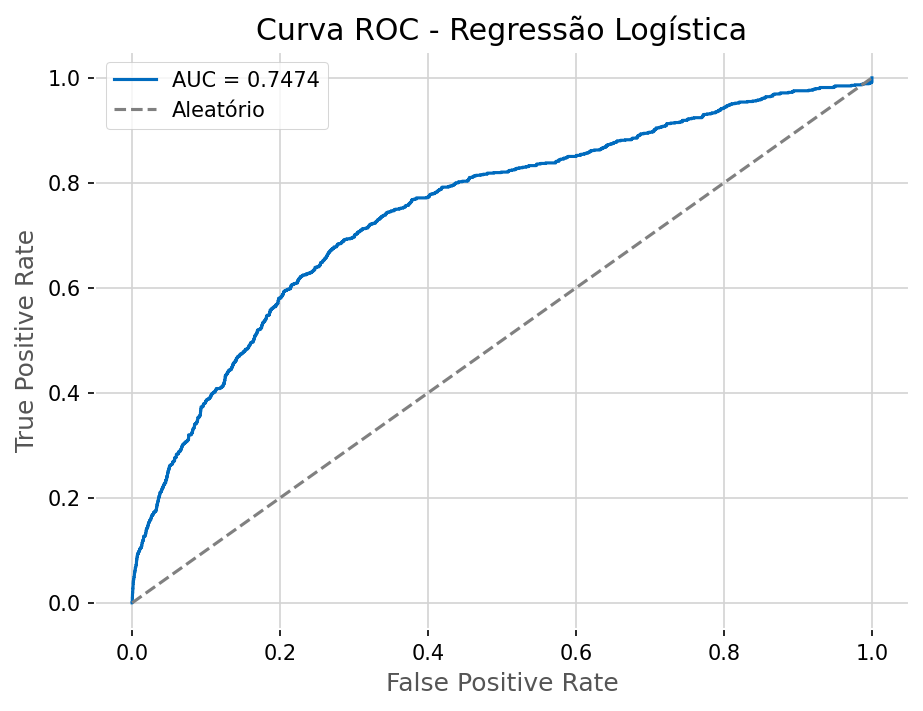

In [46]:
def plot_roc_curve(y_true, y_score, title='Curva ROC'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_roc_curve(y_test, y_probas, title='Curva ROC - Regressão Logística')

In [47]:
xgb = XGBClassifier(
    n_estimators=300,         
    learning_rate=0.05,       
    max_depth=4,                     
    n_jobs=-1,
    random_state=42    
)


baseline_xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', xgb)
])

baseline_xgb.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
y_preds = baseline_xgb.predict(X_test)
y_probas = baseline_xgb.predict_proba(X_test)[:, 1]

In [49]:
metrics_test = evaluate_global_metrics(y_test, y_probas)

pd.DataFrame(metrics_test, index=['metrics']).T

,metrics
AUC,0.824037
KS,0.536934
Gini,0.648075
Brier,0.048267


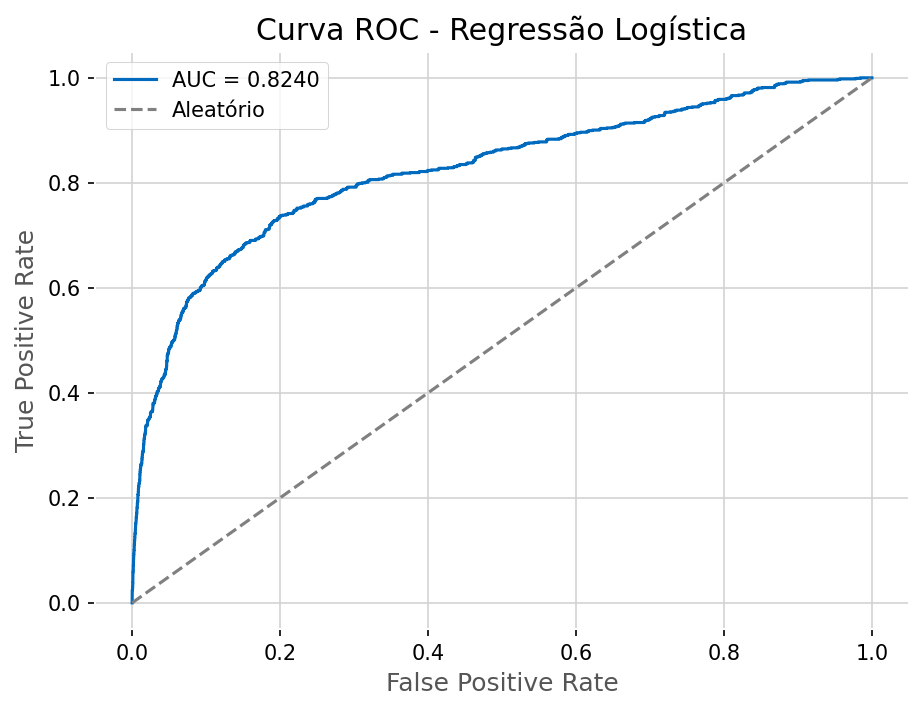

In [50]:
def plot_roc_curve(y_true, y_score, title='Curva ROC'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_roc_curve(y_test, y_probas, title='Curva ROC - Regressão Logística')


O modelo XGBoost superou amplamente o baseline linear, apresentando excelente capacidade discriminativa (AUC ≈ 0.82, KS ≈ 0.54, Gini ≈ 0.65) e notável calibração (Brier ≈ 0.048). O modelo demonstra maturidade estatística, estabilidade operacional e clareza na separação dos perfis de risco.

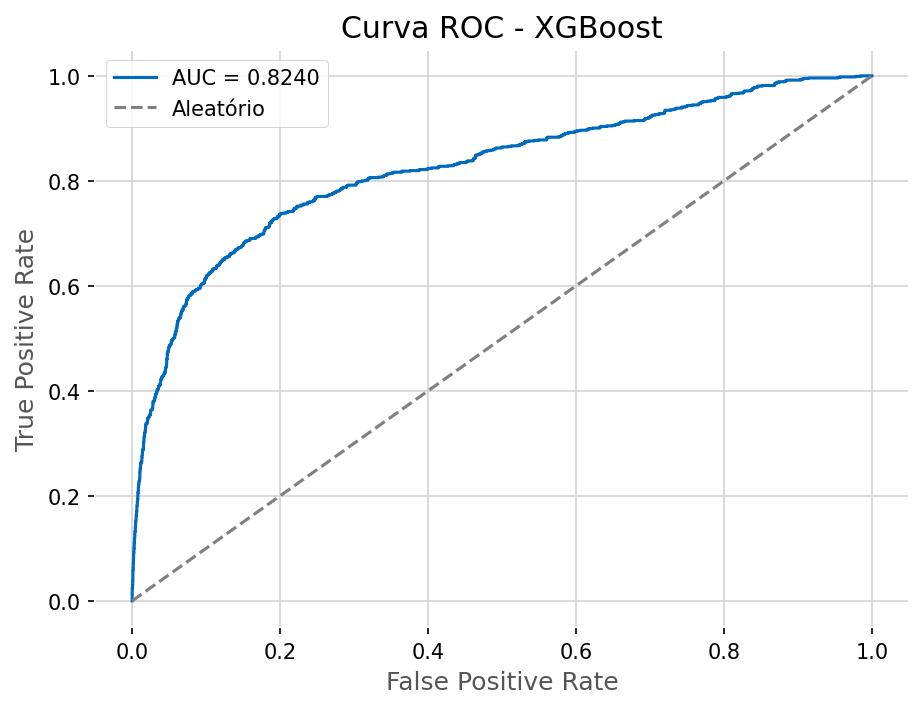

In [51]:
plot_roc_curve(y_test, y_probas, title='Curva ROC - XGBoost')

### **Conclusão sobre os modelos baseline**

- A partir da avaliação das métricas de cada modelo acima, pode-se chegar nas seguintes conclusões:
    - O modelo de Regressão Logística apresentou métricas satisfatórias, com ROC-AUC em torno de pouco mais de 0,7. Um excelente coeficiente para um base modelo como a Regressão Logística, que é computacionalmente mais barato e um modelo mais interpretável.
    - O modelo de boosting (XGBoost) apresentou um desempenho significativamente maior, cerca de mais de 0,82 de coeficiente AUC. Isso denota a força e a performance do algoritmo, que é conhecido por lidar melhor com problemas de multicolinearidade.

- A Regressão Logística apresenta custo computacional substancialmente menor do que métodos baseados em árvores, como o XGBoost. Por operar com otimização convexa e prever por meio de uma simples combinação linear de variáveis, a Logística oferece:
    - treinamento mais rápido,
    - menor custo de memória,
    - previsões mais leves e escaláveis,
    - maior facilidade de deploy.
    
Isso a torna uma excelente escolha de baseline e uma opção preferencial quando interpretabilidade e eficiência operacional são fatores críticos.

### **Feature Importance**

In [52]:
feature_names = baseline_log_reg.named_steps['preprocess'].get_feature_names_out()

feature_names

array(['num__VALOR_A_PAGAR', 'num__RENDA_MES_ANTERIOR',
       'num__NO_FUNCIONARIOS', 'num__DIA_VENCIMENTO_DOCUMENTO',
       'num__MES_VENCIMENTO_DOCUMENTO', 'num__ANO_VENCIMENTO_DOCUMENTO',
       'num__DIA_REF', 'num__MES_REF', 'num__ANO_REF',
       'num__TEMPO_RELACIONAMENTO', 'cat__FLAG_PF_0', 'cat__FLAG_PF_1',
       'cat__TAXA_4.99', 'cat__TAXA_5.99', 'cat__TAXA_6.99',
       'cat__TAXA_8.99', 'cat__TAXA_11.99',
       'cat__SEGMENTO_INDUSTRIAL_Comércio',
       'cat__SEGMENTO_INDUSTRIAL_Indústria',
       'cat__SEGMENTO_INDUSTRIAL_Serviços', 'cat__DOMINIO_EMAIL_AOL',
       'cat__DOMINIO_EMAIL_BOL', 'cat__DOMINIO_EMAIL_GMAIL',
       'cat__DOMINIO_EMAIL_HOTMAIL', 'cat__DOMINIO_EMAIL_OUTLOOK',
       'cat__DOMINIO_EMAIL_YAHOO', 'cat__PORTE_GRANDE',
       'cat__PORTE_MEDIO', 'cat__PORTE_PEQUENO', 'cat__REGIAO_DDD_0',
       'cat__REGIAO_DDD_1', 'cat__REGIAO_DDD_2', 'cat__REGIAO_DDD_3',
       'cat__REGIAO_DDD_4', 'cat__REGIAO_DDD_5', 'cat__REGIAO_DDD_6',
       'cat__REGIAO_DD

In [53]:
imp_log = get_logreg_importance(baseline_log_reg, feature_names)
imp_log.head(20)

,feature,coef,abs_coef
5,num__ANO_VENCIMENTO_DOCUMENTO,2.597154,2.597154
8,num__ANO_REF,-2.468274,2.468274
47,cat__REGIAO_CEP_8,-1.598332,1.598332
41,cat__REGIAO_CEP_2,-1.123356,1.123356
7,num__MES_REF,-1.048342,1.048342
31,cat__REGIAO_DDD_2,0.914627,0.914627
4,num__MES_VENCIMENTO_DOCUMENTO,0.868398,0.868398
30,cat__REGIAO_DDD_1,-0.785262,0.785262
44,cat__REGIAO_CEP_5,0.771466,0.771466
0,num__VALOR_A_PAGAR,-0.678352,0.678352


#### **Interpretação dos Coeficientes da Regressão Logística**

A análise dos coeficientes do modelo de Regressão Logística revela os principais fatores que influenciam o risco de inadimplência, considerando que coeficientes positivos aumentam o risco e coeficientes negativos o reduzem.

**1. Variáveis temporais são os principais determinantes de risco**

As variáveis de maior magnitude são relacionadas a **datas de vencimento e referência**:

- `ANO_VENCIMENTO_DOCUMENTO` → coeficiente fortemente positivo, indicando maior inadimplência em cobranças mais recentes.  
- `ANO_REF` → coeficiente negativo de magnitude similar, sugerindo que diferentes marcos temporais capturam variações estruturais do risco.  
- `MES_REF` e `MES_VENCIMENTO_DOCUMENTO` → evidenciam sazonalidade no comportamento de pagamento.

Esses padrões mostram que a inadimplência varia significativamente ao longo do tempo.

**2. Variáveis geográficas são fortes preditores**

Categorias como `REGIAO_CEP_8`, `REGIAO_CEP_2` e diversos `REGIAO_DDD` aparecem com coeficientes de grande magnitude.  
Isso indica que **região é um fator relevante de risco**, refletindo diferenças socioeconômicas e comportamentais entre áreas do país.

**3. Perfil do cliente exerce influência importante**

Variáveis categóricas relacionadas ao perfil cadastral também aparecem entre as mais relevantes:

- `FLAG_PF_1` → pessoas físicas apresentam risco similar, algo a ser levado em consideração, entretanto, existem poucos registros de pessoa física na base.  
- `PORTE_GRANDE` → empresas maiores tendem a inadimplir menos.  
- Domínios de email como `OUTLOOK` e `BOL` → associados a menor risco.

Esses padrões são coerentes com perfis mais estruturados e clientes de maior estabilidade.

**4. Variáveis financeiras têm efeito moderado**

- `VALOR_A_PAGAR` → coeficiente negativo; cobranças de maior valor associam-se a menor inadimplência, sugerindo efeito de seleção ou perfil financeiro mais robusto.

**5. Conclusão geral**

A regressão logística captura bem:

- tendências temporais do risco,  
- variações regionais,  
- e diferenças entre perfis de clientes.

Por outro lado, sua estrutura linear limita a captura de interações complexas, o que explica o ganho significativo de performance observado no XGBoost.  



In [55]:
import shap

prep = baseline_xgb.named_steps['preprocess']
xgb  = baseline_xgb.named_steps['clf']

In [56]:
X_train_trans = prep.transform(X_train)

In [58]:
feature_names = prep.get_feature_names_out()

feature_names

array(['num__VALOR_A_PAGAR', 'num__RENDA_MES_ANTERIOR',
       'num__NO_FUNCIONARIOS', 'num__DIA_VENCIMENTO_DOCUMENTO',
       'num__MES_VENCIMENTO_DOCUMENTO', 'num__ANO_VENCIMENTO_DOCUMENTO',
       'num__DIA_REF', 'num__MES_REF', 'num__ANO_REF',
       'num__TEMPO_RELACIONAMENTO', 'cat__FLAG_PF_0', 'cat__FLAG_PF_1',
       'cat__TAXA_4.99', 'cat__TAXA_5.99', 'cat__TAXA_6.99',
       'cat__TAXA_8.99', 'cat__TAXA_11.99',
       'cat__SEGMENTO_INDUSTRIAL_Comércio',
       'cat__SEGMENTO_INDUSTRIAL_Indústria',
       'cat__SEGMENTO_INDUSTRIAL_Serviços', 'cat__DOMINIO_EMAIL_AOL',
       'cat__DOMINIO_EMAIL_BOL', 'cat__DOMINIO_EMAIL_GMAIL',
       'cat__DOMINIO_EMAIL_HOTMAIL', 'cat__DOMINIO_EMAIL_OUTLOOK',
       'cat__DOMINIO_EMAIL_YAHOO', 'cat__PORTE_GRANDE',
       'cat__PORTE_MEDIO', 'cat__PORTE_PEQUENO', 'cat__REGIAO_DDD_0',
       'cat__REGIAO_DDD_1', 'cat__REGIAO_DDD_2', 'cat__REGIAO_DDD_3',
       'cat__REGIAO_DDD_4', 'cat__REGIAO_DDD_5', 'cat__REGIAO_DDD_6',
       'cat__REGIAO_DD

In [59]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_trans)

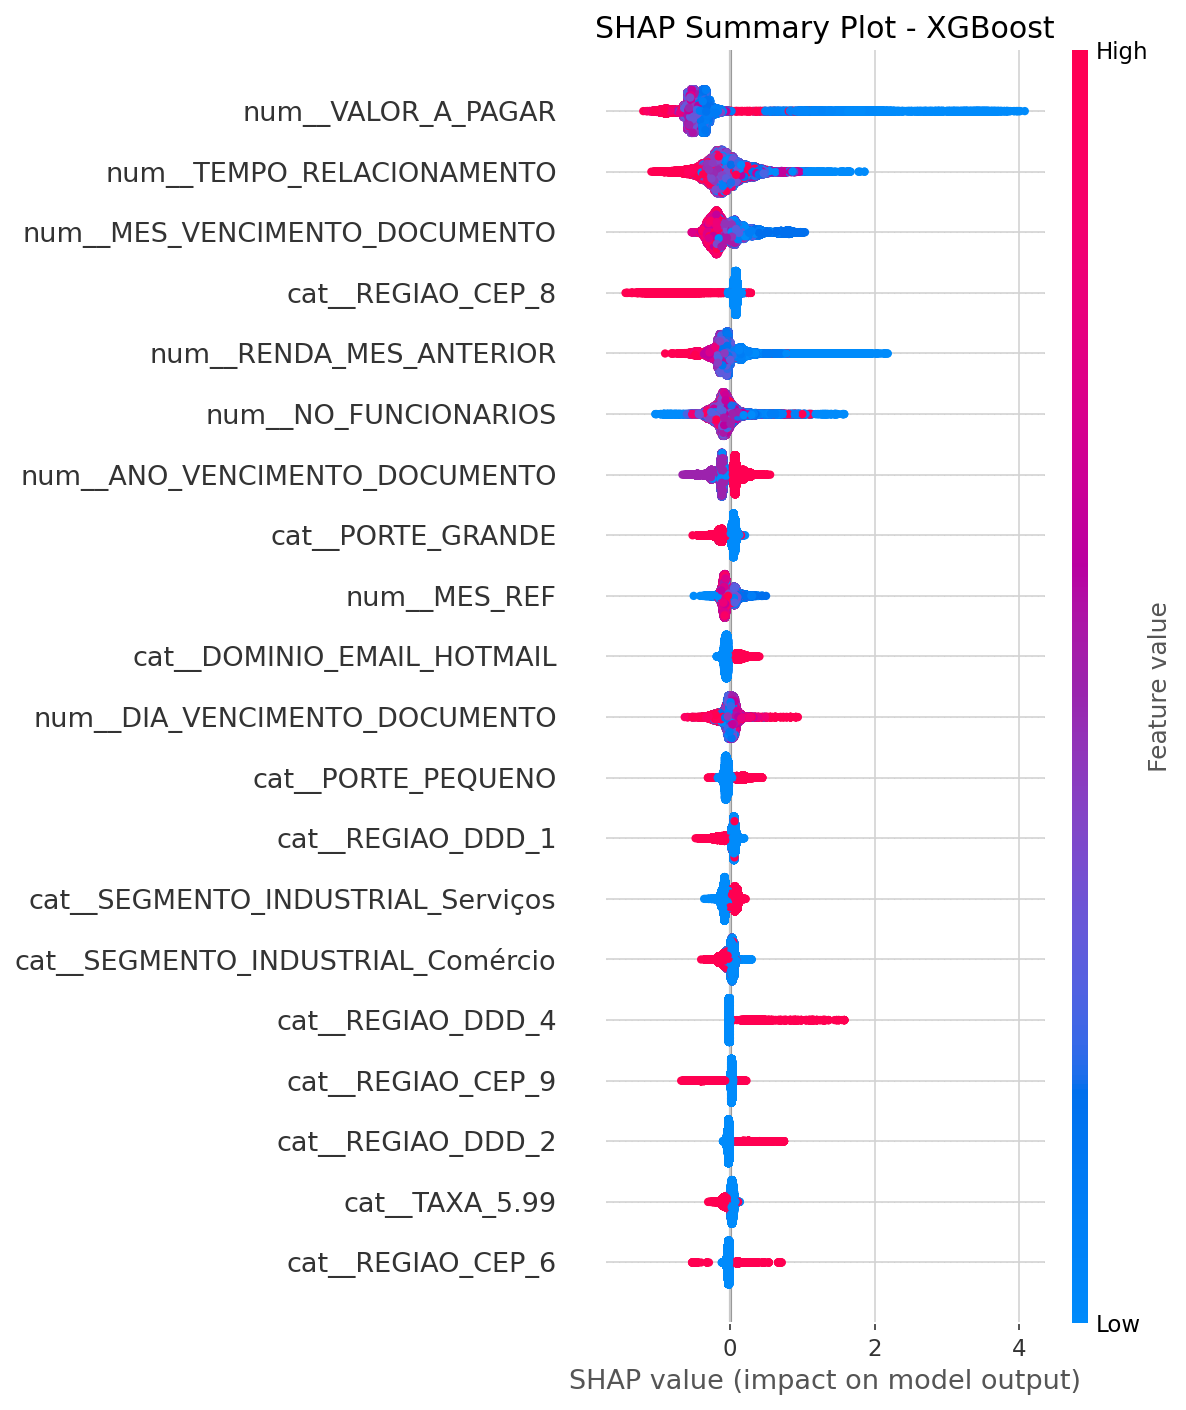

In [61]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.tight_layout()
plt.show()


### **Interpretação do SHAP Summary Plot – XGBoost**

O SHAP Summary Plot fornece uma visão global do impacto de cada variável nas previsões do XGBoost. As variáveis no topo são as mais importantes, e cada ponto representa uma observação, com sua cor indicando o valor da variável (alto = rosa, baixo = azul). A posição no eixo X indica se aquele valor aumenta ou reduz a probabilidade prevista de inadimplência.

Os principais insights são:

#### **1. Importância dominante de variáveis financeiras e comportamentais**
- **`VALOR_A_PAGAR`** é a variável mais influente no modelo. Valores mais altos (rosa) tendem a **reduzir o risco**, indicando que clientes com boletos maiores são, em média, melhores pagadores.
- **`TEMPO_RELACIONAMENTO`** também aparece com forte impacto: relacionamentos mais longos tendem a ser associados a **menor inadimplência**, enquanto clientes recém-cadastrados concentram maior risco.

#### **2. Sazonalidade e efeitos temporais claros**
Variáveis como:
- `MES_VENCIMENTO_DOCUMENTO`  
- `MES_REF`  
- `DIA_VENCIMENTO_DOCUMENTO`  
- `ANO_VENCIMENTO_DOCUMENTO`

mostram que o modelo utiliza intensamente padrões temporais. Determinados meses e dias aumentam sensivelmente o risco previsto, evidenciando **ciclos e sazonalidade real na inadimplência**.

#### **3. Perfil empresarial e características cadastrais influenciam o risco**
Variáveis como:
- `PORTE_GRANDE`  
- `PORTE_PEQUENO`  
- `SEGMENTO_INDUSTRIAL_Comércio`  
- `SEGMENTO_INDUSTRIAL_Serviços`

indicam diferenças consistentes entre segmentos e portes. Empresas maiores e setores mais estruturados tendem a gerar menor risco, enquanto perfis menores ou mais voláteis contribuem positivamente para o risco.

#### **4. Região e comportamento geográfico aparecem como fatores relevantes**
Categorias como `REGIAO_CEP_8`, `REGIAO_CEP_9` e vários `REGIAO_DDD` participantes entre as top features revelam que **risco é heterogêneo geograficamente**, alinhado à diversidade socioeconômica das regiões.

#### **5. SHAP valida e aprofunda a análise da regressão logística**
Mesmo sendo um modelo mais complexo, o XGBoost se mostra coerente com o comportamento observado no modelo linear:
- variáveis temporais e geográficas dominam o risco,
- relacionamento e valor têm peso importante,
- e características de porte e segmento complementam a explicação.

O SHAP adiciona a isso a capacidade de capturar **relações não lineares e interações**, justificando o grande ganho de performance do XGBoost sobre a Regressão Logística.


